# Econ 138 Problem Set 2 – Data Science for Economists

Author: IVAN GEORG S. PALOMATA  
GitHub: https://github.com/ispalomata  
Date: May 2025

> PEP8 styling, clean variable names, and structured sections are observed.

In [49]:
pip install geopandas matplotlib contextily rasterio shapely pyproj folium osmnx openpyxl rasterstats

In [269]:
# Core libraries
import os
import numpy as np
import pandas as pd

# Geospatial libraries
import geopandas as gpd
from shapely.geometry import Point, mapping, box

# Raster data processing
import rasterio
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.plot import show

# Zonal statistics
from rasterstats import zonal_stats

# Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors

This section imports all the necessary Python libraries used for geospatial data processing, raster analysis, plotting, and statistical computations. These packages allow the notebook to handle shapefiles, raster data, coordinate transformations, zonal statistics, and customized visualizations, all essential for replicating spatial figures from development economics papers. 

# South Africa

This section recreates Figure 2 from Mettetal (2019), with a modification replacing river gradient with population density as the background variable. The map overlays the locations of hydrodams across South Africa on a downsampled population raster from WorldPop (2020), adjusted to UN estimates. The raster is clipped at the 99th percentile to reduce the influence of outliers and enhance visual contrast. Hydrodams are plotted as red points, and municipal boundaries are outlined in black to provide spatial reference. 

By integrating population density instead of river gradient, the map emphasizes the relationship between hydrodams and human settlement patterns. The visual reveals that many hydrodams are located near or within moderately to densely populated areas, underscoring their relevance to both urban infrastructure and regional development. The final output closely aligns with the structure of the original figure, while offering a different yet policy-relevant perspective on dam placement and its intersection with population needs. 

In [230]:
# Define file paths
BASE_DIR = "D:/Problem Set 2/South Africa"
dams_path = os.path.join(BASE_DIR, "Dams_south_africa.xlsx")
muni_path = os.path.join(BASE_DIR, "MDB_Local_Municipal_Boundary_2018.shp")
pop_path = os.path.join(BASE_DIR, "zaf_ppp_2020_UNadj.tif")

This section defines the file paths needed for the South Africa map replication. It first sets a base directory where all project files are stored, then specifies the individual paths for the hydrodams Excel file, the municipal boundary shapefile, and the population density raster. These paths are used to efficiently load and manage the spatial datasets required to visualize hydrodams overlaid on a population density background within South Africa's administrative boundaries. 

In [232]:
# Load dam data and convert DMS to decimal degrees
def dms_to_dd(deg, minutes, seconds):
    return deg + (minutes / 60) + (seconds / 3600)

dams_df = pd.read_excel(dams_path)
dams_df["Latitude"] = dams_df.apply(lambda row: -dms_to_dd(row["Latitude deg"], row["Lat min"], row["Lat sec"]), axis=1)
dams_df["Longitude"] = dams_df.apply(lambda row: dms_to_dd(row["Longitude deg"], row["Long min"], row["Long sec"]), axis=1)

dams_gdf = gpd.GeoDataFrame(
    dams_df,
    geometry=gpd.points_from_xy(dams_df["Longitude"], dams_df["Latitude"]),
    crs="EPSG:4326"
)

This step loads the hydrodams dataset from an Excel file and converts the geographic coordinates from degrees, minutes, and seconds (DMS) format to decimal degrees (DD), which is the standard format for most geospatial analysis. Since the dams are located in the Southern Hemisphere, latitude values are made negative. After conversion, the data is transformed into a GeoDataFrame with point geometries representing each dam's location, and the coordinate reference system is set to WGS84 (`EPSG:4326`) to ensure compatibility with other spatial layers. 

In [234]:
# Load municipal boundaries
muni_gdf = gpd.read_file(muni_path)

This line loads the shapefile containing South Africa's municipal boundaries into a GeoDataFrame. These boundaries provide the administrative context for the map, allowing hydrodams and population density to be visualized within the country's local government areas. This layer is essential for spatial reference and for aligning other datasets to a consistent geographic framework. 

In [236]:
# Load and downsample population raster
with rasterio.open(pop_path) as src:
    scale = 4
    out_shape = (src.count, src.height // scale, src.width // scale)
    pop_data = src.read(out_shape=out_shape, resampling=Resampling.average)
    transform = src.transform * src.transform.scale(
        (src.width / pop_data.shape[-1]),
        (src.height / pop_data.shape[-2])
    )
    raster_crs = src.crs

This block loads the population density raster for South Africa and downsamples it to reduce its resolution, making it more efficient to process and visualize. The raster is read using `rasterio`, and its dimensions are scaled down by a factor of four using average resampling, which preserves overall spatial trends while minimizing memory usage. The spatial transformation is adjusted accordingly to reflect the new resolution, and the coordinate reference system of the raster is stored for later alignment with other spatial layers. 

In [238]:
# Reproject vector data to match raster CRS
dams_gdf = dams_gdf.to_crs(raster_crs)
muni_gdf = muni_gdf.to_crs(raster_crs)

This step reprojects the dam and municipal boundary GeoDataFrames to match the coordinate reference system of the population raster. This ensures that all spatial layers are aligned in the same geographic projection, allowing them to be accurately overlaid and visualized together on the same map. Consistent CRS across datasets is essential for correct spatial analysis and mapping. 

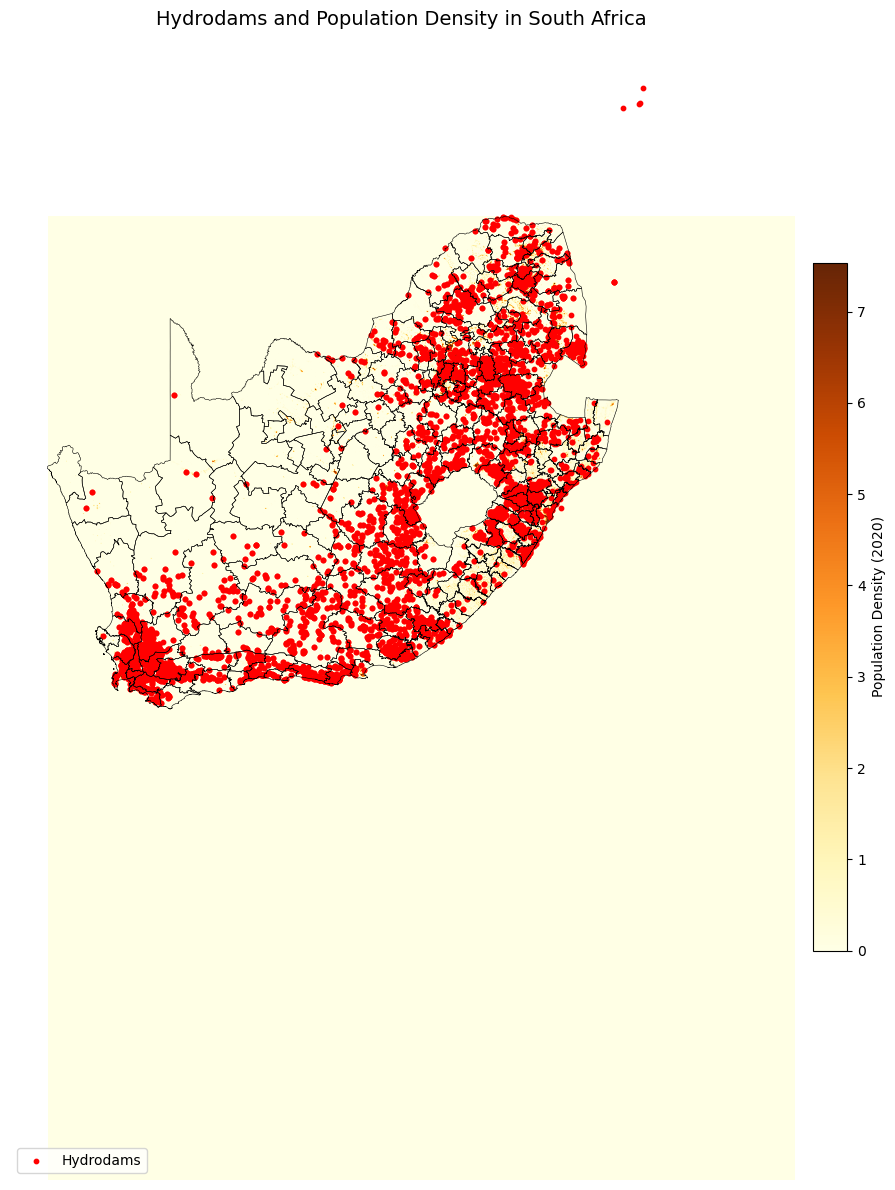

In [240]:
# Plot population density raster with dams and boundaries

# Clip extreme values for contrast
pop_vis = pop_data[0].copy()
clip_threshold = np.percentile(pop_vis[pop_vis > 0], 99)
pop_vis[pop_vis > clip_threshold] = clip_threshold

fig, ax = plt.subplots(figsize=(10, 12))

# Plot raster background
raster_img = ax.imshow(
    pop_vis,
    cmap="YlOrBr",
    vmin=0,
    vmax=clip_threshold,
    extent=[
        transform[2],
        transform[2] + pop_vis.shape[1] * transform[0],
        transform[5] + pop_vis.shape[0] * transform[4],
        transform[5]
    ],
    origin='upper'
)

# Add colorbar
cbar = plt.colorbar(raster_img, ax=ax, shrink=0.6, pad=0.02)
cbar.set_label("Population Density (2020)", fontsize=10)

# Overlay municipal boundaries
muni_gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=0.4)

# Plot dams
dams_gdf.plot(ax=ax, color='red', markersize=10, label="Hydrodams")

# Final layout
ax.set_title("Hydrodams and Population Density in South Africa", fontsize=14)
ax.set_axis_off()
ax.legend(loc='lower left')
plt.tight_layout()
plt.show()

This block generates the final map visualizing hydrodams in South Africa overlaid on a background of population density and municipal boundaries. To enhance visual clarity, extreme population values are clipped at the 99th percentile, which helps bring out variation across most of the country. The population raster is plotted using a yellow-to-brown colormap (`YlOrBr`), and a colorbar is added to interpret the density values. Municipal boundaries are outlined in black to provide geographic reference, and the hydrodams are plotted as red points to highlight their locations. The result is clear, well-layered map that replicates the structure of Figure 2 from Mettetal (2019), with population density replacing the original river gradient. 

Darker shades in the yellow-to-brown color scale represent areas of higher population concentration, while lighter shades indicate more sparsely populated regions. Municipal boundaries provide administrative context, delineating local government areas across the country. 

Red dots on the map mark the locations of hydrodams, revealing their geographic dispersion relative to population centers. Many dams appear to be situated near moderately to densely populated areas, particularly in the northeast and central regions, suggesting their role in supporting urban and agricultural demand. At the same time, some dams are located in remore or less populated regions, indicating their importance for regional water supply and infrastructure development. 

Overall, the map provides a clear visual representation of how hydrodams are distributed across South Africa's population landscape. It highlights the alignment, and in some cases, the distance, between critical water infrastructure and population needs, effectively reflecting the analytical purpose of the original figure with a meaningful substitution of population density for river gradient. 

# Ethiopia

This section recreates Figure 4 from Fried & Lagakos (2021), which visualizes population density across Ethiopia overlaid with the locations of the sample villages from the Ethiopian Rural Socioeconomic Survey (ERSS). The 2020 population raster was sourced from WorldPop and downsampled for performance, with extreme values clipped at the 99th percentile to enhance visual contrast. The population density is rendered using the `"YlOrBr"` color scale to match the original figure's aesthetic and emphasize variation across densely and sparsely populated areas. 

Village locations were extracted from ERSS geovariables, coverted to geographic points, and plotted over the raster. Administrative boundaries were included to provide spatial context. The map also features a population density colorbar and a legend for village data, ensuring intrepretability. 

The final output closely mirrors the structure and visual clarity of the original figure. It effectively illustrates the spatial distribution of both population and survey coverage across Ethiopia, confirming the ERSS's reach across diverse demographic and geographic settings. 

In [184]:
# Load Ethiopia admin boundary
ethiopia_admin = gpd.read_file("D:/Problem Set 2/Ethiopia/Ethiopia_AdminBoundaries.shp")
ethiopia_geom = [ethiopia_admin.geometry.union_all().__geo_interface__]

This step loads Ethiopia's administrative boundary shapefile using GeoPandas. The `ethiopia_admin` GeoDataFrame contains the polygon geometries for administrative regions, which are used to overlay boundary lines on the final map. The second line combines all individual geometries into a single unified geometry (`ethiopia_geom`) using `union_all()`. This allows for consistent spatial masking or clipping if needed, and ensures the entire national boundary is available for plotting and analysis.

In [192]:
# Load and downsample population raster
with rasterio.open("D:/Problem Set 2/Ethiopia/ETH_ppp_2020_1km_Aggregated_UNadj.tif") as src:
    scale = 2  # Downsample by 2x to avoid memory errors
    new_height = src.height // scale
    new_width = src.width // scale

    pop_data = src.read(
        out_shape=(src.count, new_height, new_width),
        resampling=Resampling.average
    )

    transform = src.transform * src.transform.scale(
        (src.width / pop_data.shape[-1]),
        (src.height / pop_data.shape[-2])
    )

This step loads the population density raster for Ethiopia from a GeoTIFF file and downsamples it to reduce memory usage and improve rendering performance. The raster is read using `rasterio`, and its resolution is reduced by a factor of 2 in both width and height using average resampling. The transformation matrix is also adjusted to reflect the new resolution. This processed raster can then be visualized more efficiently while still conveying the spatial distribution of population density across the country. 

In [194]:
# Load and prepare ERSS village point data
village_df = pd.read_csv("D:/Problem Set 2/Ethiopia/pub_eth_householdgeovariables_y1.csv")
village_df = village_df.dropna(subset=["LAT_DD_MOD", "LON_DD_MOD"])

village_points = [Point(xy) for xy in zip(village_df["LON_DD_MOD"], village_df["LAT_DD_MOD"])]
village_gdf = gpd.GeoDataFrame(village_df, geometry=village_points, crs="EPSG:4326")
village_gdf = village_gdf.to_crs(ethiopia_admin.crs)

This section processes the geospatial data for ERSS sample villages. The data is first read from a CSV file, and any rows missing geographic coordinates are removed. The remaining latitude and longitude values are converted into geometric point objects to form a GeoDataFrame. The coordinate reference system is initially set to WGS84 (`EPSG:4326`), which uses degrees, and then reprojected to match the CRS of the administrative boundary layer. This ensures that all spatial layers align correctly when plotted together.

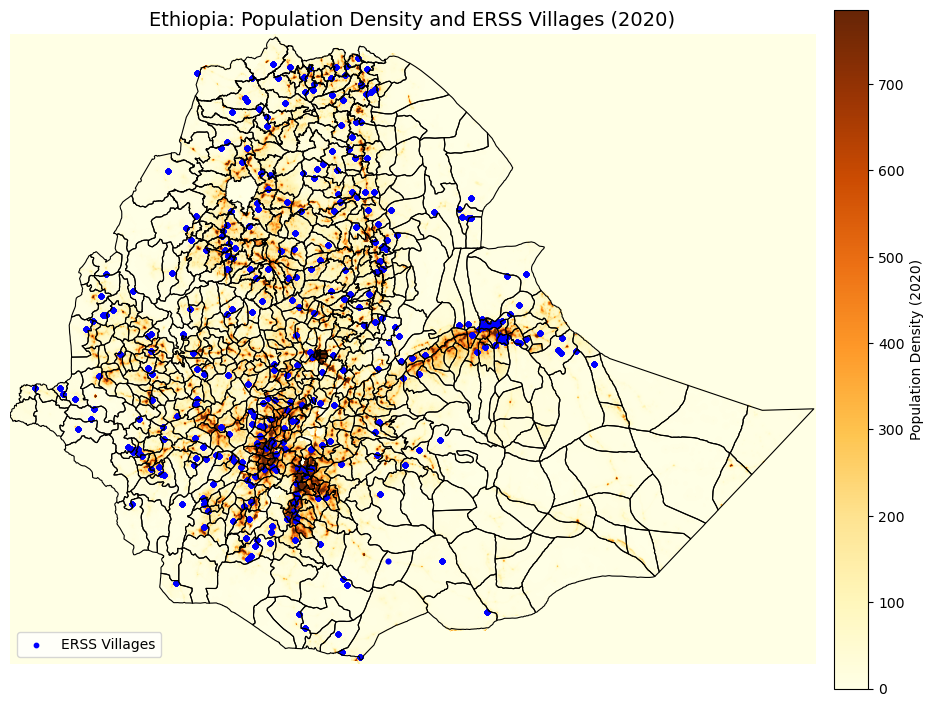

In [224]:
# Plot population raster with ERSS villages

# Improve visual contrast by clipping raster values at the 95th percentile
pop_vis = pop_data[0].copy()
clip_threshold = np.percentile(pop_vis[pop_vis > 0], 99)
pop_vis[pop_vis > clip_threshold] = clip_threshold

fig, ax = plt.subplots(figsize=(10, 10))

# Plot raster using imshow for colorbar support
raster_img = ax.imshow(
    pop_vis,
    cmap="YlOrBr",
    vmin=0,
    vmax=clip_threshold,
    extent=[
        transform[2],
        transform[2] + pop_vis.shape[1] * transform[0],
        transform[5] + pop_vis.shape[0] * transform[4],
        transform[5]
    ],
    origin='upper'
)

# Add colorbar
cbar = plt.colorbar(raster_img, ax=ax, shrink=0.7, pad=0.02)
cbar.set_label("Population Density (2020)", fontsize=10)

# Plot boundaries and villages
ethiopia_admin.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8)

if 'region' in village_gdf.columns:
    village_gdf.plot(ax=ax, column='region', cmap='tab10', markersize=10, legend=True, legend_kwds={'title': 'Region'})
else:
    village_gdf.plot(ax=ax, color='blue', markersize=10, label='ERSS Villages')
    ax.legend(loc='lower left')

# Styling
ax.set_title("Ethiopia: Population Density and ERSS Villages (2020)", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()

This block produces the final version of the Ethiopia map, replicating Figure 4 from Fried & Lagakos (2021) with full visual styling and interpretability. The population density raster is first clipped at the 99th percentile to reduce the influence of outliers and enhance contrast in low-to-medium density areas. It is plotted using `imshow`, which allows for the inclusion of a colorbar that conveys the meaning of the color gradient. 

Administrative boundaries are plotted on top of the raster to provide spatial reference. ERSS villages are overlaid either in a single color (blue). A legend is included for the village layer, and the final map is titled and styled for clarity, with axis markings removed to focus attention on spatial patterns. 

The color gradient ranges from light yellow (low density) to dark brown (high density), clearly showing dense population clusters around Addis Ababa and other central and northern highland areas. Peripheral regions such as the east, west, and parts of the south appear much more sparsely populated. 

The ERSS sample villages are dispersed across a wide area, reflecting an effort to capture a diverse cross-section of Ethiopia's demographic and geographic variation. Their concentration in both high and moderate density regions suggests good national coverage by the survey. The overlay of administrative boundaries further contextualizes these patterns, making it easier to relate village locations and density clusters to regional divisions. 

Overall, the map successfully replicates the analytical purpose of the original figure, showing how population distribution aligns with the reach of nationally representative rural surveys. 

# Vietnam

This section recreates Figure 10 from Balboni (2025), which visualizes Vietnam's road infrastructure and its connection to major urban centers. Using OpenStreetMap shapefiles sourced from Geofabrik, the road network was filtered to highlight key road classes, motorway, trunk, primary, secondary, and tertiary, each styled with distinct colors and line widths to reflect their relative importance. 

The map also includes the manually defined locations of Hanoi and Ho Chi Minh City, using UTM coordinates for precise spatial alignment. All spatial layers, including the roads, cities, and a separate coastline shapefile, were projected to UTM Zone 48N (EPSG:32648) to ensure consistent scaling and geographic accuracy. 

The final figure emphasizes the north-south alignment of Vietnam's transportation network and the central roles of its coastal cities. By layering the transport hierarchy over the national geography, the map captures the structure and coastal orientation of Vietnam's development, reflecting the analytical focus of the original figure. While limited to road and city layers, the replication closely mirrors the visual and spatial intent of the original work. 

In [149]:
# Load roads and coastline
roads = gpd.read_file("D:/Problem Set 2/Vietnam/gis_osm_roads_free_1.shp")
coastline = gpd.read_file("D:/Problem Set 2/Vietnam/ne_10m_coastline_VNM_VN_UTM48N.shp")

This step loads two key spatial datasets for Vietnam. The first is a shapefile of road infrastructure sourced from OpenStreetMap via Geofrabrik, containing various road types across the country. The second is a coastline shapefile that provides geographic context by outlining Vietnam's land-water boundaries. Both datasets are read into GeoDataFrames using GeoPandas, enabling spatial analysis and mapping. These layers serve as the foundation for visualizing the transport network and its relationship to Vietnam's coastal geography.

In [151]:
# Define city coordinates (UTM Zone 48N)
cities_data = {
    'city': ['Hanoi', 'Ho Chi Minh City'],
    'x': [587923.508, 684921.752],
    'y': [2326393.604, 1192495.372]
}
cities_df = pd.DataFrame(cities_data)
cities_geometry = [Point(xy) for xy in zip(cities_df['x'], cities_df['y'])]
cities = gpd.GeoDataFrame(cities_df, geometry=cities_geometry, crs="EPSG:32648")

This step manually defines the geographic locations of Vietnam's two major cities, Hanoi and Ho Chi Minh City, using their UTM Zone 48N (EPSG:32648) coordinates. The coordinates are converted into point geometries and stored in a GeoDataFrame. This allows the cities to be accurately plotted and spatially aligned with the road and coastline data, which are in the same coordinate reference system. This approach was necessary due to the absence of a pre-existing shapefile of major Vietnamese cities. 

In [153]:
roads = roads.to_crs("EPSG:32648")
coastline = coastline.to_crs("EPSG:32648")
# Cities already created in EPSG:32648

This step ensures that all spatial layers, the road network and coastline, are projected into the same coordinate reference system: UTM Zone 48N (EPSG:32648). This projection uses meters as its unit of measurement, making it more suitable for accurate mapping and spatial analysis within Vietnam. Since the city coordinates were already defined in EPSG:32648, no transformation was necessary for the city layer. Aligning all layers under the same CRS ensures that they overlay correctly on the final map. 

In [154]:
# Filter major road types for styled plotting
major_roads = roads[roads['fclass'].isin([
    'motorway', 'primary', 'secondary', 'tertiary', 'trunk'
])]

This line filters the road dataset to include only the most important road types: motorways, primary, secondary, tertiary, and trunk roads. These categories represent the core of Vietnam's transport infrastructure and are typically used for regional and intercity travel. By selecting only these road classes, the final map emphasizes the hierarchical structure of the road network while avoiding visual clutter from smaller, local roads. 

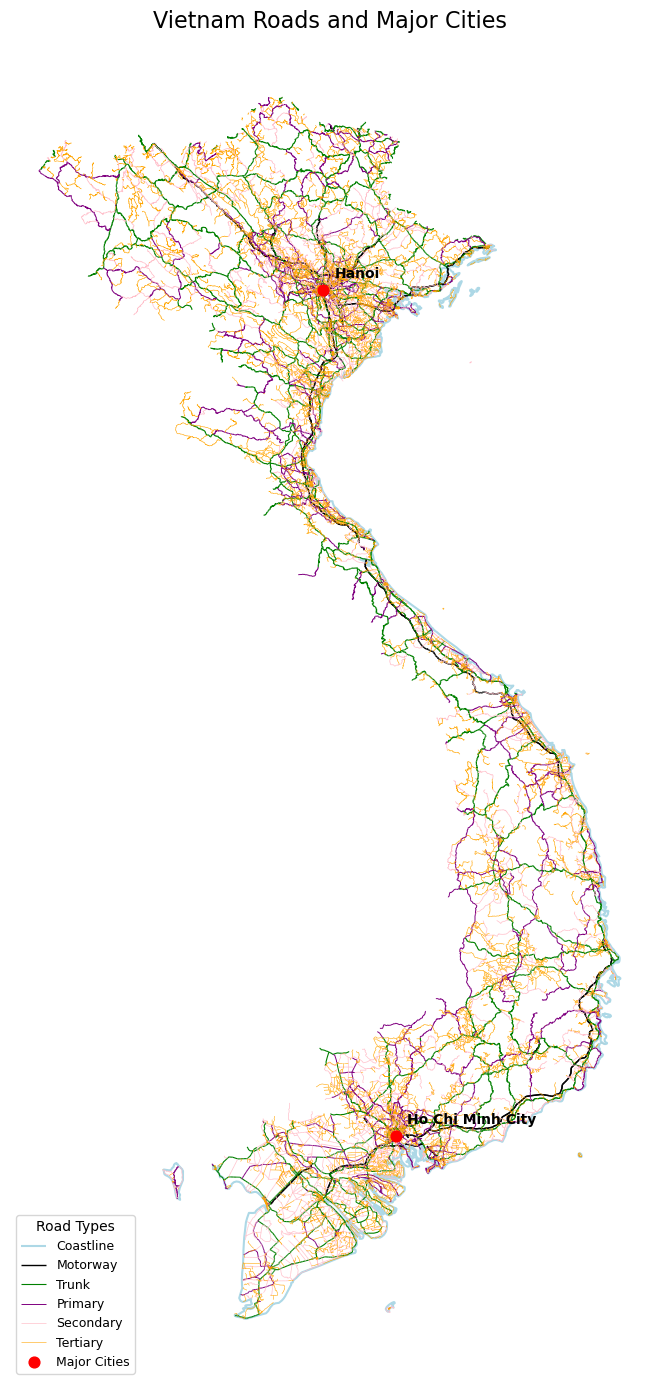

In [175]:
fig, ax = plt.subplots(figsize=(12, 14))

# Plot layers in order
coastline.plot(ax=ax, color='lightblue', edgecolor='black', label='Coastline', zorder=1)

# Separate by road class for visual distinction
motorway = roads[roads['fclass'] == 'motorway']
primary = roads[roads['fclass'] == 'primary']
secondary = roads[roads['fclass'] == 'secondary']
tertiary = roads[roads['fclass'] == 'tertiary']
trunk = roads[roads['fclass'] == 'trunk']

motorway.plot(ax=ax, color='black', linewidth=1.0, label='Motorway', zorder=2)
trunk.plot(ax=ax, color='green', linewidth=0.8, label='Trunk', zorder=2)
primary.plot(ax=ax, color='purple', linewidth=0.7, label='Primary', zorder=2)
secondary.plot(ax=ax, color='pink', linewidth=0.5, label='Secondary', zorder=2)
tertiary.plot(ax=ax, color='orange', linewidth=0.4, label='Tertiary', zorder=2)
cities.plot(ax=ax, color='red', markersize=60, label='Major Cities', zorder=3)

# City labels
for x, y, label in zip(cities.geometry.x, cities.geometry.y, cities['city']):
    ax.text(x + 15000, y + 15000, label, fontsize=10, fontweight='bold', color='black', zorder=4)

# Title & legend
ax.set_title("Vietnam Roads and Major Cities", fontsize=16)
ax.set_axis_off()
ax.legend(title='Road Types', loc='lower left', fontsize=9, title_fontsize=10)

plt.tight_layout()
plt.show()

This block generates the final map of Vietnam, visually distinguishing different road types and highlighting major cities. The map layers are plotted in order to ensure clear visual hierarchy: the coastline is shown in light blue for geographic context, followed by individual road types styled with distinct colors and line widths to represent different classifications (e.g., motorways, trunk, primary, etc.). Major cities, represented by red markers, are overlaid with text labels for identification. The use of `zorder` ensures proper layering, and the legend explains the road classifications. The overall layout is styled to closely replicate the structure and thematic intent of the original figure in Balboni (2025). 

The map reveals a strong coastal orientation in Vietnam's infrastructure, with major roads running in a north-south direction along the country's elongated coastline. Hanoi and Ho Chi Minh City are clearly positioned as central nodes, with multiple primary and trunk roads converging in their vicinity. This emphasizes the critical role these cities play in the country's spatial and economic structure. 

The addition of the coastline layer provides geographic context, reinforcing how Vietnam's urban and transport development is closely tied to its coastal geography, a key theme in Balboni (2025). Overall, the map successfully replicates the intent of the original figure by illustrating the structure, hierarchy, and urban linkage of Vietnam's road network. 

# Brazil

This section aimed to reproduce Figure 1 from Morten & Oliveira (2024), which depicts Brasilia alongside the national road infrastructure of Brazil. Due to data availability constraints, the replication could not cover the entire country. Geofrabrik, the source of OpenStreetMap shapefiles, no longer provides a complete shapefile for Brazil and instead distributes road data by subregions. 

As a result, the replication focused on the Centro-Oeste region, which includes Brasilia. Road network data for this region were obtained from Geofrabrik and reprojected to a UTM coordinate system suitable for spatial analysis. A custom GeoDataFrame of major Brazilian cities was created using latitude and longitude coordinates, reprojected to match the road data, and clipped to the extent of the available shapefile. While this limited the geographic coverage of the final map, it successfully captured the spatial relationships between Brasilia and its surrounding infrastructure, approximating the visual style of the original figure within the constraints of the available data. 

In [131]:
# Load roads shapefile (Centro-Oeste region)
roads = gpd.read_file("D:/Problem Set 2/Brazil/gis_osm_roads_free_1.shp")
roads = roads.to_crs("EPSG:32723")

This step loads the road network data for Brazil's Centro-Oeste region from a shapefile sourced from OpenStreetMap. The data is then reprojected from its original geographic coordinate system (latitude/longitude) to UTM Zone 23 South (EPSG:32723), which uses meters as units, making it more suitable for regional mapping and spatial analysis.

In [136]:
# Create GeoDataFrame for major cities across Brazil
cities_data = [
    ("Brasília", -15.793889, -47.882778),
    ("São Paulo", -23.550520, -46.633308),
    ("Rio de Janeiro", -22.906847, -43.172896),
    ("Salvador", -12.977749, -38.501629),
    ("Fortaleza", -3.717220, -38.543300),
    ("Belo Horizonte", -19.916681, -43.934493),
    ("Manaus", -3.119028, -60.021731),
    ("Curitiba", -25.428954, -49.267137),
    ("Recife", -8.047562, -34.877000),
    ("Porto Alegre", -30.034647, -51.217659),
    ("Goiânia", -16.686882, -49.264788),
    ("Campo Grande", -20.469710, -54.620121),
    ("Palmas", -10.249091, -48.324285),
    ("Cuiabá", -15.601410, -56.097891)
]
df = pd.DataFrame(cities_data, columns=["city", "lat", "lon"])
geometry = [Point(xy) for xy in zip(df["lon"], df["lat"])]
cities_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
cities_gdf = cities_gdf.to_crs(roads.crs)

This step creates a GeoDataFrame containing geographic coordinates of major Brazilian cities, including Brasilia and several state capitals. The coordinates are first specified in latitude and longitude (WGS84 - EPSG:4326), and then converted into geometric point objects. These points are assembled into a GeoPandas GeoDataFrame, which is then reprojected to match the coordinate reference system of the road network data. This ensures spatial consistency between the cities and roads layers when visualizing or analyzing them on the same map. 

In [139]:
# Clip cities to road extent
xmin, ymin, xmax, ymax = roads.total_bounds
bbox = box(xmin, ymin, xmax, ymax)
cities_clipped = cities_gdf[cities_gdf.geometry.within(bbox)]

This step restricts the set of cities to only those that fall within the spatial extent of the available road network data. First, the geographic bounds of the roads layer are extracted. A bounding box is then constructed from these bounds, and the cities GeoDataFrame is filtered to include only cities whose coordinates lie within this box. This ensures that only relevant cities, those located within the same region covered by the road data, are included in the final map. 

In [142]:
# Filter major roads for clarity
major_roads = roads[roads['fclass'].isin(['motorway', 'trunk', 'primary'])]

This line filters the road network to include only major road types, specifically motorways, trunk roads, and primary roads. These categories represent the most significant routes in terms of connectivity and traffic flow. By selecting only these road types, the resulting map emphasizes the core transportation infrastructure and avoids visual clutter from smaller, local roads.

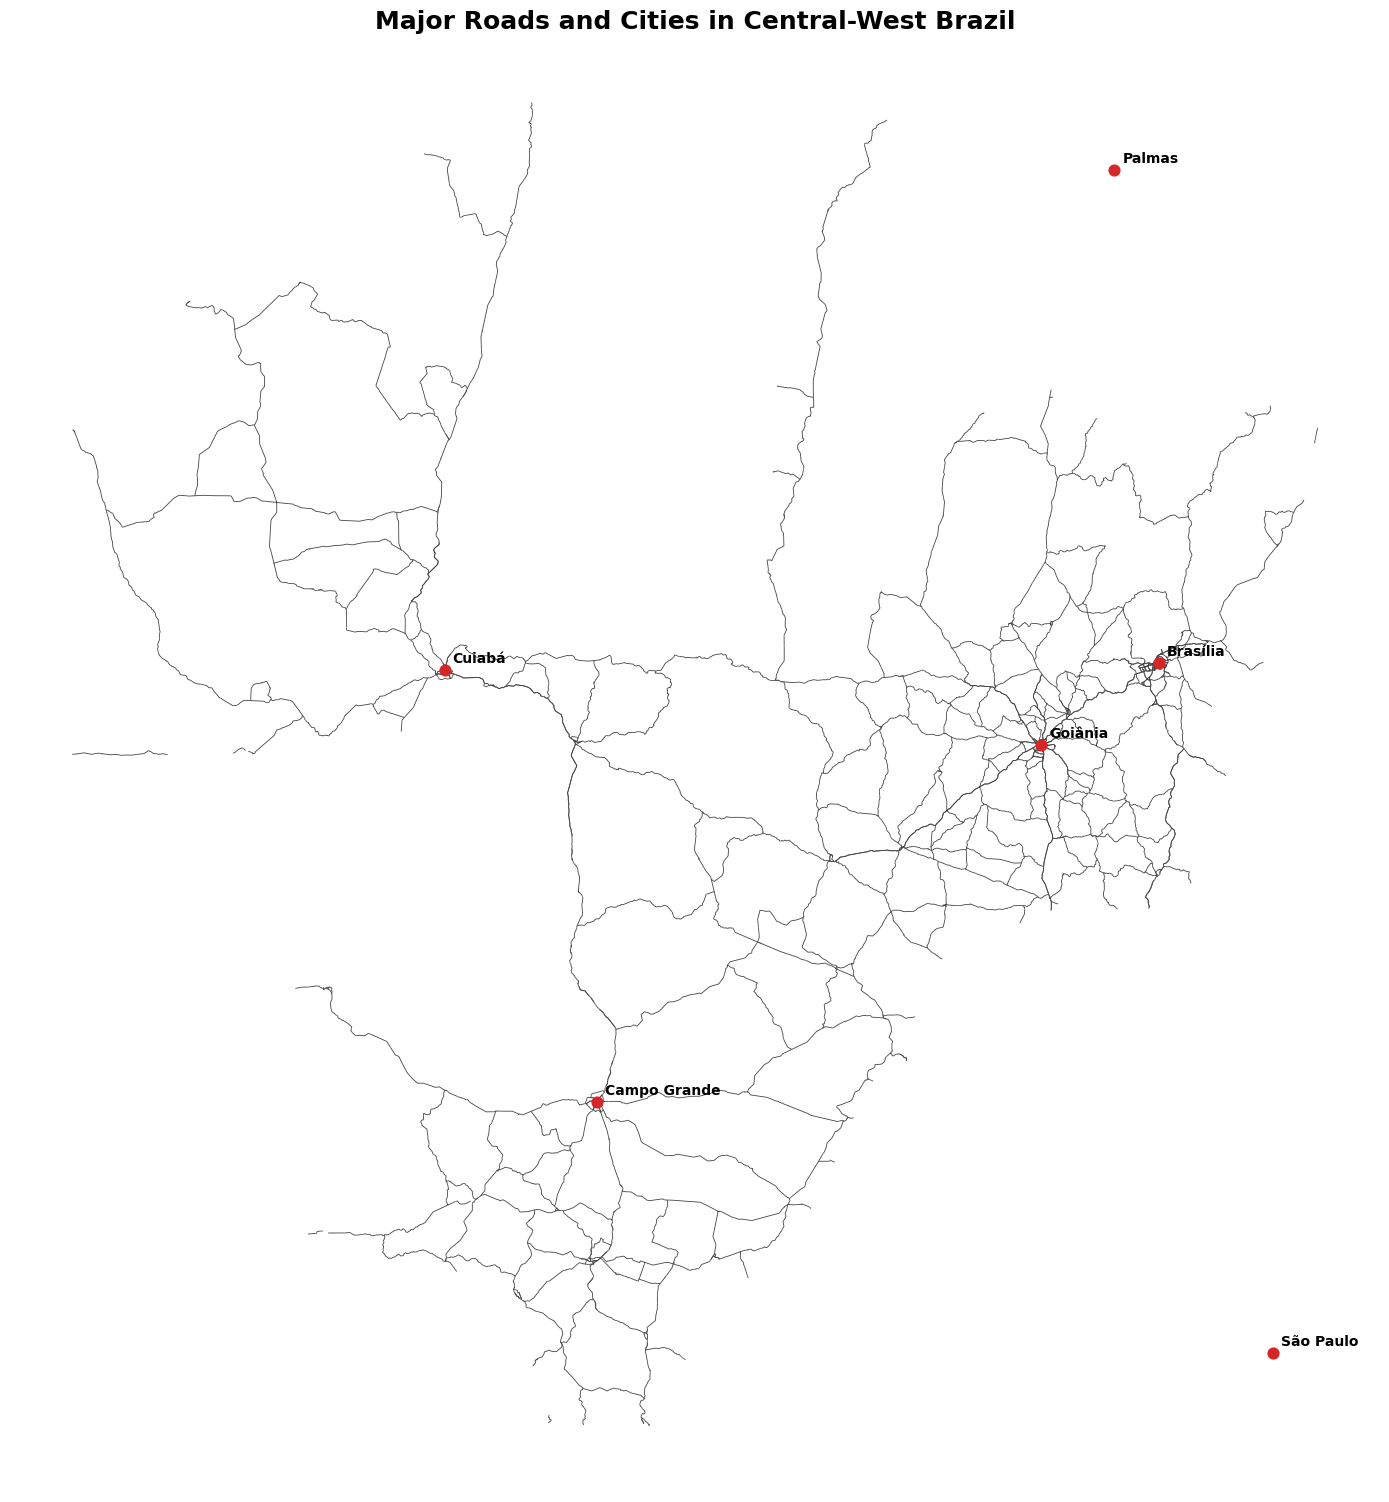

In [145]:
# Plot with aesthetic styling
fig, ax = plt.subplots(figsize=(14, 16))

# Plot layers
major_roads.plot(ax=ax, color='#444444', linewidth=0.6, zorder=1)
cities_clipped.plot(ax=ax, color='#d62728', markersize=60, zorder=2)

# Add city labels
for x, y, label in zip(cities_clipped.geometry.x, cities_clipped.geometry.y, cities_clipped['city']):
    ax.text(x + 10000, y + 10000, label, fontsize=10, fontweight='bold', color='black', zorder=3)

# Styling
ax.set_facecolor("white")
ax.set_title("Major Roads and Cities in Central-West Brazil", fontsize=18, fontweight='bold')
ax.set_axis_off()
plt.tight_layout()
plt.show()

This block generates the final map visualization with clean and readable styling. It begins by creating a Matplotlib figure and axis, then plots the filtered major roads in dark gray and the selected cities in red. Each city is labeled with its name, slightly offset for visibility. The map is styled with a white background, no axis ticks or borders, and a clear title. This ensures the resulting figure highlights the spatial relationship between major cities and the road network in Brazil's Central-West region in a visually appealing format. 

The map reveals a radial structure centered around Brasilia, consistent with its design as a planned capital with a centralized infrastructure layout. Several major roads extend outward from the capital, linking it to nearby cities such as Goiania, Campo Grande, and Cuiaba, emphasizing its role as a hub for regional connectivity. 

While the map excludes road data from other Brazilian regions, the inclusion of clipped city labels suggests the broader geographic context and highlights the limited reach of the Centro-Oeste shapefile. Despite this, the map effectively illustrates the spatial organization of transport routes in central Brazil and their alignment with key urban locations, providing a regional snapshot of the infrastructure layout discussed in Morten & Oliveira (2024).